In [1]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# load data
processed_path = "./processed_data.parquet"
df = pd.read_parquet(processed_path)

# load vocab
vocab_df = pd.read_csv("./vocab.csv")
vocab = {word: idx for word, idx in zip(vocab_df["word"], vocab_df["id"])}
reverse_vocab = {idx: word for word, idx in vocab.items()}  # get reverse vocab

# extract sequences
sequences = df["desc_seq"].tolist()

In [11]:
# count the number of unknown tokens
def count_unk(sequences, unk_id):
    total_tokens = 0
    unk_count = 0

    for seq in sequences:
        if isinstance(seq, np.ndarray):
            total_tokens += len(seq)
            unk_count += np.count_nonzero(seq == unk_id)
        else:
            total_tokens += len(seq)
            unk_count += seq.count(unk_id)

    return {
        "Total Tokens": total_tokens,
        "<unk> Count": unk_count,
        "<unk> Ratio": f"{unk_count / total_tokens * 100:.2f}%"
    }

title_stats = count_unk(df["title_seq"].tolist(), vocab["<unk>"])
print("count <unk> in title :", title_stats)

desc_stats = count_unk(df["desc_seq"].tolist(), vocab["<unk>"])
print("count <unk> in description:", desc_stats)

count <unk> in title : {'Total Tokens': 830761, '<unk> Count': 9181, '<unk> Ratio': '1.11%'}
count <unk> in description: {'Total Tokens': 2614913, '<unk> Count': 47365, '<unk> Ratio': '1.81%'}


In [4]:
# check data types
print("vocab id data types:", type(next(iter(reverse_vocab.keys())))) 

sample_seq = df["title_seq"].iloc[0]
print("sequences id data types:", type(sample_seq[0]))  

vocab id data types: <class 'int'>
sequences id data types: <class 'numpy.int64'>


In [5]:
class TrigramModel:
    def __init__(self):
        self.ngram_counts = defaultdict(lambda: defaultdict(int))  # store the candidate words and their counts
        self.vocab_size = len(vocab)

    def train(self, sequences):
        # train the model
        for seq in sequences:
            # add start and end tokens
            for i in range(len(seq) - 2):
                context = (seq[i], seq[i+1])
                next_word = seq[i+2]
                self.ngram_counts[context][next_word] += 1

    def predict_next(self, context):
        # predict the next word
        candidates = self.ngram_counts.get(context, {})
        if not candidates:
            return vocab["<unk>"]  # default to unknown token
        return max(candidates, key=candidates.get)

    def generate_text(self, seed_words, max_length=20):
        # generate text given a seed
        seed = [vocab.get(word, vocab["<unk>"]) for word in seed_words]
        if len(seed) < 2:
            seed = [vocab["<start>"]] * (2 - len(seed)) + seed

        generated = seed.copy()
        for _ in range(max_length):
            context = tuple(generated[-2:])
            next_word = self.predict_next(context)
            if next_word == vocab["<end>"]:
                break
            generated.append(next_word)

        return " ".join([reverse_vocab.get(idx, "<unk>") for idx in generated])

In [6]:
model = TrigramModel()
model.train(sequences)

In [7]:
# make preditions
context = (vocab["new"], vocab["york"])
next_word = model.predict_next(context)
print(f"Context: ['new', 'york'] → Predicted next: {reverse_vocab[next_word]}")

context = (vocab["york"], vocab["times"])
next_word = model.predict_next(context)
print(f"Context: ['york', 'times'] → Predicted next: {reverse_vocab[next_word]}")

generated = model.generate_text(["stock", "market"])
print("Generated:", generated)

Context: ['new', 'york'] → Predicted next: reuters
Context: ['york', 'times'] → Predicted next: reported
Generated: stock market debut thursday , killing people wounding 20 , 2004 , pm pt . fourth priority main focus improving obtaining crm


In [8]:
def get_top_probabilities(context, top_n=15):
    # get the top n most probable words given a context
    probabilities = model.ngram_counts.get(context, {})
    if not probabilities:
        return {}

    # calculate total count for normalization
    total = sum(probabilities.values())

    # convert counts to probabilities and sort
    sorted_probs = sorted(
        [(reverse_vocab[word], count/total) for word, count in probabilities.items()],
        key=lambda x: -x[1]  
    )

    # get top n results
    return {
        word: f"{prob*100:.2f}%"
        for word, prob in sorted_probs[:top_n]
    }

probs = get_top_probabilities((vocab["interest"], vocab["rates"]))
print("'interest rates' top 15 candidate words:")
for word, prob in probs.items():
    print(f"{word}: {prob}")

'interest rates' top 15 candidate words:
.: 14.10%
,: 9.76%
time: 4.99%
quarter: 2.60%
expected: 2.60%
shortterm: 2.39%
hold: 1.95%
year: 1.95%
tuesday: 1.95%
<unk>: 1.52%
peaked: 1.52%
fourth: 1.52%
fifth: 1.52%
rise: 1.30%
steady: 1.30%


In [9]:
probs2 = get_top_probabilities((vocab["economic"], vocab["growth"]))
print("'economic growth' top 15 candidate words:")
for word, prob in probs2.items():
    print(f"{word}: {prob}")

'economic growth' top 15 candidate words:
.: 14.67%
,: 9.28%
slow: 4.79%
slowed: 4.49%
forecast: 2.99%
year: 2.69%
china: 2.69%
quarter: 2.10%
<unk>: 1.80%
second: 1.50%
figures: 1.50%
2004: 1.50%
inflation: 1.50%
fueled: 1.50%
percent: 1.20%


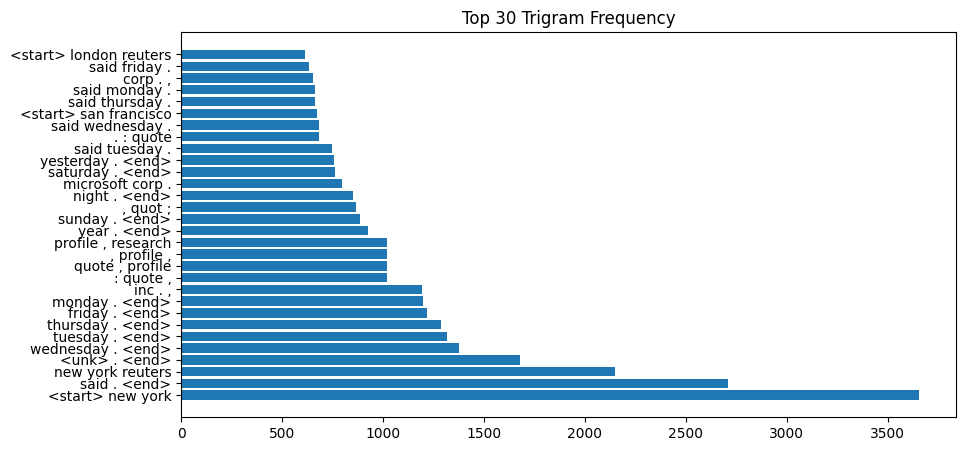

In [10]:
# visualize the top trigram frequencies
trigram_freq = []
for context, candidates in model.ngram_counts.items():
    for word, count in candidates.items():
        word_str = str(reverse_vocab.get(int(word), "<unk>"))  
        context_str = (
            str(reverse_vocab.get(int(context[0]), "<unk>")),
            str(reverse_vocab.get(int(context[1]), "<unk>"))
        )
        trigram = (*context_str, word_str)
        trigram_freq.append((" ".join(trigram), count))

top_trigrams = sorted(trigram_freq, key=lambda x: -x[1])[:30]
words, counts = zip(*top_trigrams)

plt.figure(figsize=(10,5))
plt.barh(words, counts)
plt.title("Top 30 Trigram Frequency")
plt.show()